In [1]:
import tensorflow as tf
from tensorflow import keras
import theano.tensor as T
import pymc3 as pm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tfmodel = keras.models.load_model('../test_grid_model.h5')

In [3]:
tfmodel.summary()

Model: "test_grid_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
outputs (Dense)              (None, 3)                 33        
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________


In [4]:
weights_list = tfmodel.get_weights()

In [5]:
def nn(input):
    nh_layers = int(len(weights_list) / 2 - 2)
    xx = T.nnet.elu(pm.math.dot(input, weights_list[0]) + weights_list[1])
    for hl in range(1, 1+nh_layers):
        xx = T.nnet.elu(pm.math.dot(xx, weights_list[hl * 2]) + weights_list[hl * 2 + 1])
    xx = pm.math.dot(xx, weights_list[-2]) + weights_list[-1]
    return 10**(xx)

In [6]:
params = ['star_age', 'initial_mass']
obs = ['radius', 'effective_T', 'delta_nu']

In [7]:
nn([np.log10(4.5), np.log10(1.0)]).eval()

array([1.14267237e+00, 6.08204420e+03, 1.13291452e+02])

In [8]:
Nstars = 10
ages = np.random.rand(Nstars) * 3.0 + 2.0
masses = np.random.randn(Nstars) * 0.05 + 1.0
inputs = np.array([ages , masses]).T
outputs = nn(inputs).eval()

In [9]:
obs_unc = np.array([[0.01, 70.0, 1.0] for n in range(Nstars)])
obs_ = outputs + np.random.randn(*outputs.shape) * obs_unc
print(obs_.shape)

(10, 3)


In [10]:
model = pm.Model()
X = obs_[:, 2][:, None]

with model:
    mass = pm.Normal('mass', 1.0, 0.2, shape=Nstars)
    age = pm.Normal('age', 4.5, 3.0, shape=Nstars)
    
    slist = [[age[m], mass[m]] for m in range(Nstars)]
    obs_prop = pm.Deterministic('obs_prop', nn(T.stacklists(slist)))
    
    like_r = pm.Normal('like_r', obs_prop[:, 0], obs_unc[:, 0], observed=obs_[:, 0])
    like_T = pm.Normal('like_T', obs_prop[:, 1], obs_unc[:, 1], observed=obs_[:, 1])
    y = obs_prop[:, 2] - obs_[:, 2]
    
    cov_func = 1.0 * pm.gp.cov.ExpQuad(1, ls=30)
    gp = pm.gp.Marginal(cov_func=cov_func)
    y_ = gp.marginal_likelihood("y_", X=X, y=y, noise=obs_unc[:, 2])

/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [11]:
inits = ['adapt_diag']
start = {'mass': [1.0 for n in range(Nstars)], 'age': [4.5 for n in range(Nstars)]}

with model:
    trace = pm.sample(tune=1000, init=inits[0], start=start, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age, mass]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


/Users/davies/Library/Python/3.7/lib/python/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


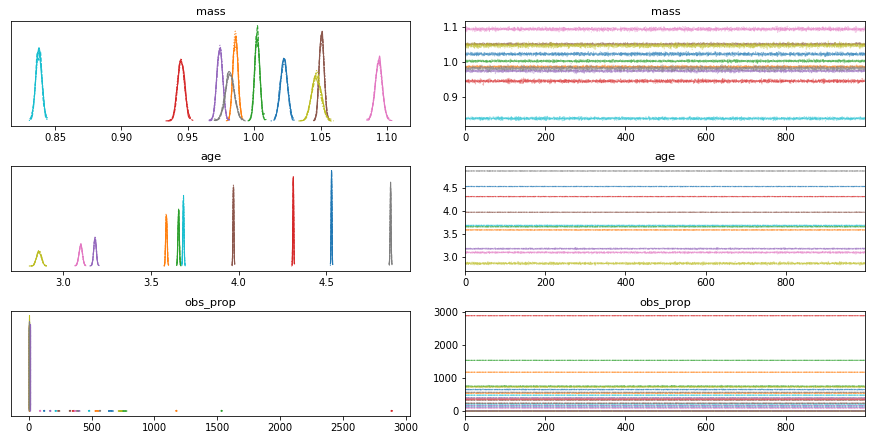

In [12]:
pm.traceplot(trace);

In [13]:
pm.summary(trace)

/Users/davies/Library/Python/3.7/lib/python/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mass[0],1.022,0.003,1.017,1.027,0.000,0.000,4907.0,4907.0,4887.0,2593.0,1.0
mass[1],0.986,0.002,0.982,0.989,0.000,0.000,4968.0,4967.0,4932.0,2982.0,1.0
mass[2],1.002,0.002,0.999,1.006,0.000,0.000,4980.0,4980.0,4983.0,2513.0,1.0
mass[3],0.945,0.003,0.940,0.950,0.000,0.000,5844.0,5844.0,5867.0,2777.0,1.0
mass[4],0.974,0.002,0.970,0.978,0.000,0.000,4788.0,4788.0,4800.0,2417.0,1.0
mass[5],1.051,0.002,1.048,1.054,0.000,0.000,5174.0,5174.0,5165.0,2713.0,1.0
mass[6],1.094,0.003,1.088,1.099,0.000,0.000,4936.0,4936.0,4943.0,2462.0,1.0
mass[7],0.982,0.003,0.976,0.988,0.000,0.000,5508.0,5508.0,5590.0,2375.0,1.0
mass[8],1.047,0.003,1.040,1.053,0.000,0.000,4874.0,4874.0,4859.0,2694.0,1.0
mass[9],0.838,0.002,0.834,0.842,0.000,0.000,5856.0,5855.0,5808.0,3220.0,1.0


1.0220318032655693 1.0223769571370294
0.9864967998676281 0.9858623875853707
0.9997921391639468 1.0022633883113987
0.939041245269443 0.9448945079754808
0.972629601285107 0.974059290536408
1.0529640303408954 1.0508535187183012
1.0964445268260288 1.0938182349850643
0.9811206910561555 0.9816576910036611
1.0456021778853943 1.0468825300434952
0.8390349205158668 0.8376953302499146


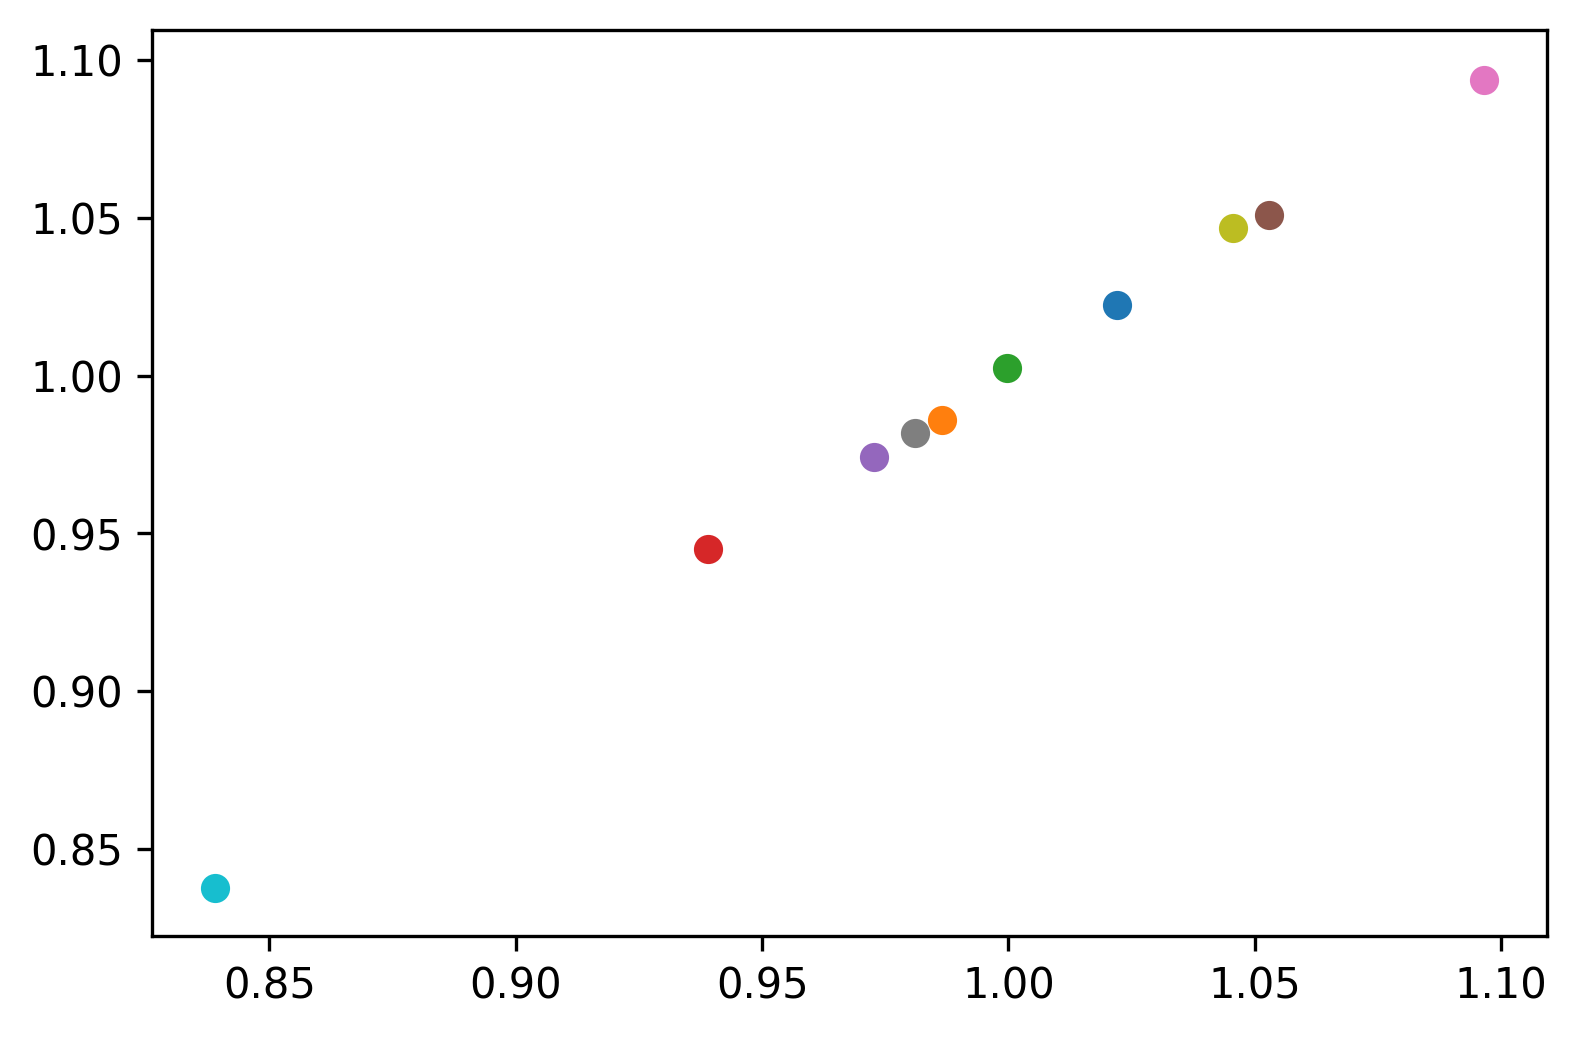

In [14]:
fig, ax = plt.subplots(dpi=300)
for idx, i in enumerate(masses):
    print(i, np.mean(trace['mass'][:, idx]))
    ax.scatter(i, np.mean(trace['mass'][:, idx]))
    ax.errorbar(i, np.mean(trace['mass'][:, idx]), yerr=np.std(trace['mass'][:, idx]))

In [15]:
Xnew = np.linspace(40, 250, 200)[:, None]

with model:
    f_star = gp.conditional("f_star", Xnew=Xnew)

/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [16]:
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_star], samples=2000)

/Users/davies/Library/Python/3.7/lib/python/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/davies/Library/Python/3.7/lib/python/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


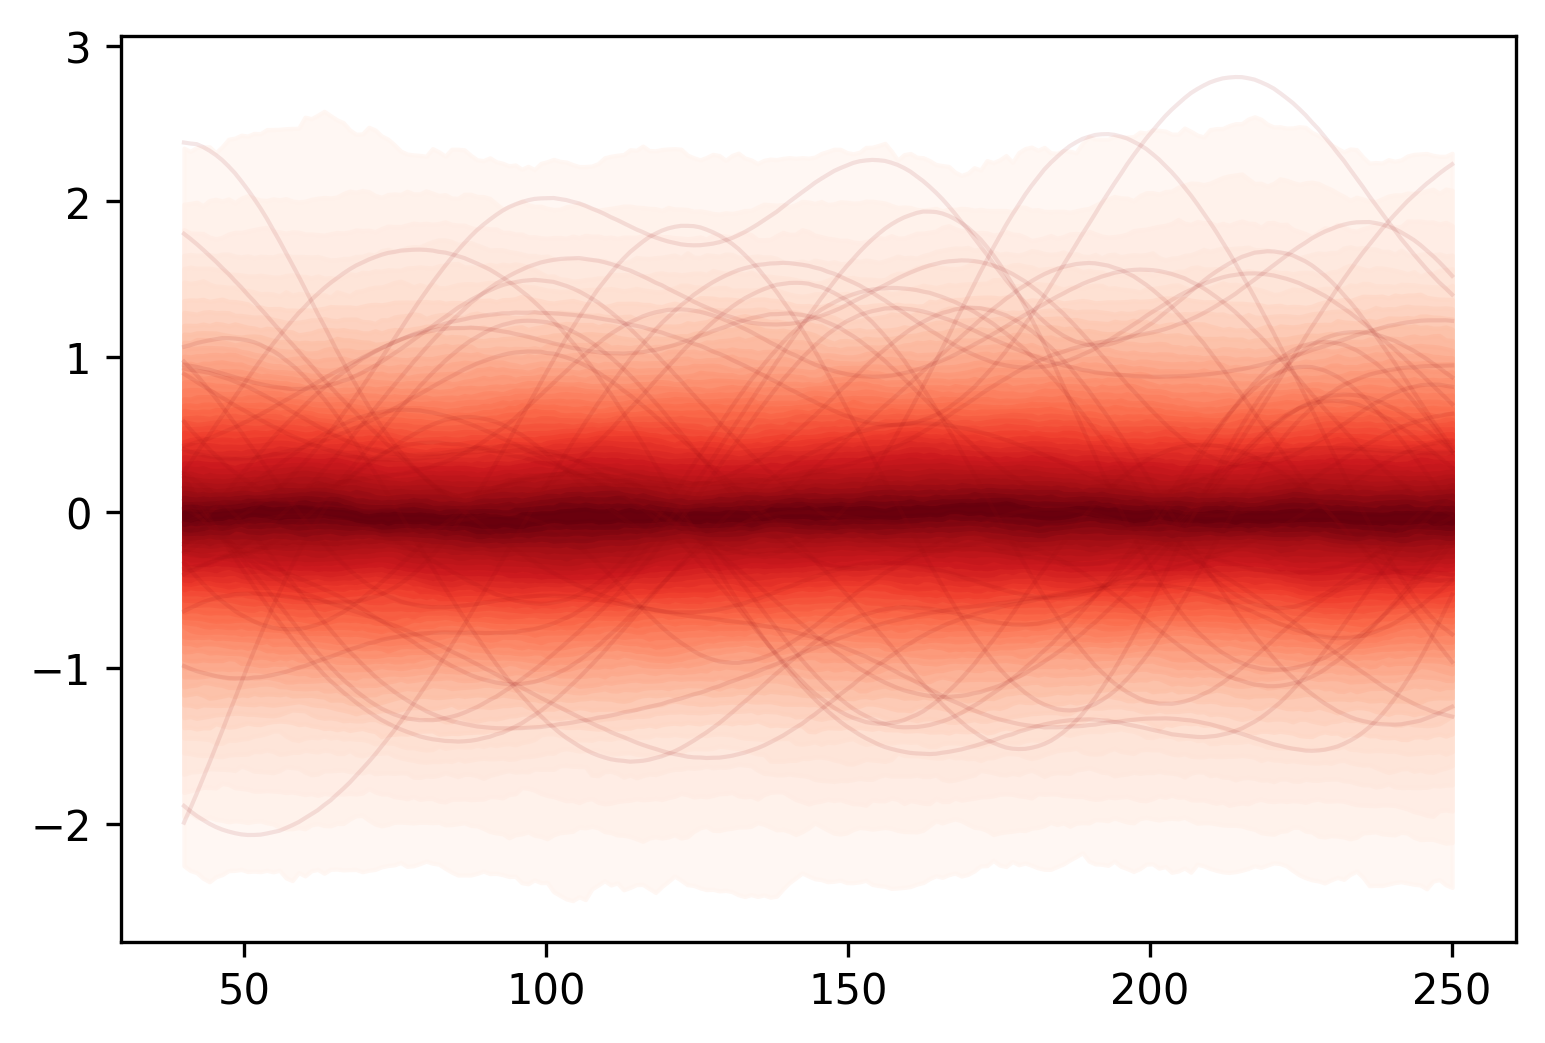

In [17]:
fig = plt.figure(dpi=300); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_star"], Xnew);